In [14]:
import os
import numpy as np
import pandas as pd
from datetime import date

import sklearn
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from mlxtend.classifier import StackingClassifier
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DATA_ROOT = "../data/ml100marathon-02-01/"

In [15]:
# Read data to df
or_dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
or_dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
# or_dfsample = pd.read_csv(os.path.join(DATA_ROOT,'sample_submission.csv'))

## 特徵分析

In [202]:
or_dfoff.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [193]:
null_value = or_dfoff[or_dfoff['Distance'].isnull()]['Date'].isna().value_counts()
distance_na_buy_p = null_value[0]/null_value.sum()
print(buy_p)

x = []
y = []

for i in range(0,11):
    value_series = or_dfoff[or_dfoff['Distance']==i]['Date'].isna().value_counts()
    prop = value_series[0]/value_series.sum()
    x.append(i)
    y.append(prop)

X = np.array(x).reshape(-1,1)
Y = np.array(y).reshape(-1,1)
T = np.array([10]).reshape(-1,1)
print(Y)

e = GradientBoostingRegressor()
e.fit(X, Y)
pred = e.predict(T)
pred

0.06033569157620371
[[0.63134375]
 [0.37260625]
 [0.28323559]
 [0.2422437 ]
 [0.2193189 ]
 [0.20232873]
 [0.19002336]
 [0.1745231 ]
 [0.17344513]
 [0.16110196]
 [0.10851705]]


array([0.10919976])

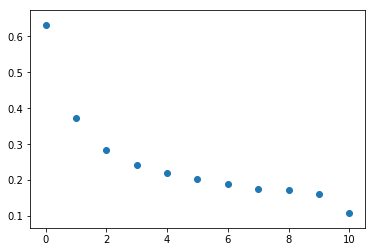

In [195]:
plt.scatter(X, Y)

## 特徵轉換 function

In [16]:
def trans_id_to_string(df):
    df = df.copy()
    df['USER_ID'] = df['User_id'].astype('str')
    df['MERCHANT_ID'] = df['Merchant_id'].astype('str')
    df['COUPON_ID'] = df['Coupon_id'].apply(trans_coupon_id)
    return df

def trans_coupon_id(value):
    if np.isnan(value):
        return 'None'
    else:
        return str(int(value))

In [17]:
# Convert distance
def convert_distance(df):
    df = df.copy()
    df.loc[df.Distance.isna(), "Distance"] = 10
    return df

In [18]:
# Check data
dfoff = convert_distance(dfoff)
dfoff.head(10)

NameError: name 'dfoff' is not defined

In [19]:
# Convert discunt_rate
def convert_rate(value):
    if value == 'nan':
        return 1.0
    elif ':' in value:
        values = value.split(':')
        return 1.0 - float(values[1])/float(values[0])
    else:
        return float(value)

def find_discount_type(value):
    if value == 'nan':
        return 'None'
    elif ':' in value:
        return '1'
    else:
        return '0'

def find_discount_require(value):
    if ':' in value:
        values = value.split(':')
        return int(values[0])
    else:
        return 0

def find_discount_off(value):
    if ':' in value:
        values = value.split(':')
        return int(values[1])
    else:
        return 0

In [210]:
# Check data
dfoff['DISCOUNT_RATE'] = dfoff['Discount_rate'].astype('str').apply(convert_rate)
dfoff['DISCOUNT_TYPE'] = dfoff['Discount_rate'].astype('str').apply(find_discount_type)
dfoff['DISCOUNT_REQUIRE'] = dfoff['Discount_rate'].astype('str').apply(find_discount_require)
dfoff['DISCOUNT_OFF'] = dfoff['Discount_rate'].astype('str').apply(find_discount_off)
dfoff.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,LABEL,DISCOUNT_RATE,DISCOUNT_TYPE,...,DISCOUNT_OFF,WEEKDAY,WEEKEND,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,1.00,None,...,0,NaN,0,0,0,0,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,0.95,1,...,1,3.0,0,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,0.95,1,...,1,6.0,1,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,0.90,1,...,20,5.0,1,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,0.90,1,...,20,5.0,1,0,0,0,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,0.50,1,...,5,5.0,1,0,0,0,0,1,0,0
6,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,0,0.90,1,...,10,7.0,1,0,0,0,0,0,0,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0,0.85,1,...,30,4.0,0,0,0,0,1,0,0,0
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0,0.90,1,...,20,6.0,1,0,0,0,0,0,1,0
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0,0.90,1,...,20,2.0,0,0,1,0,0,0,0,0


In [20]:
# Date_received to weekday
def expand_date_received(df):
    df = df.copy()
    
    # Year
    df['YEAR'] = df['Date_received'].apply(get_year)
    
    # Month
    df['MONTH'] = df['Date_received'].apply(get_month)
    
    # Day
    df['DAY'] = df['Date_received'].apply(get_day)
    
    # Weekday
    df['WEEKDAY'] = df['Date_received'].apply(get_weekday)
    
    # Weekend
    df['WEEKEND'] = df['WEEKDAY'].apply(lambda x : 1 if x in range(6, 8) else 0 ) # apply to trainset
    
    # Weekday One Hot Encode
    weekday_dummies = pd.get_dummies(df['WEEKDAY'])
    weekday_columns = ['WEEKDAY_' + str(i) for i in range(1,8)]
    weekday_dummies.columns = weekday_columns
    for i in weekday_dummies.columns:
        df[i] = weekday_dummies[i]
    
    return df

def get_year(value):
    if (np.isnan(value)):
        return 'None'
    else:
        return str(int(pd.to_datetime(value, format = "%Y%m%d").year))

def get_month(value):
    if (np.isnan(value)):
        return 'None'
    else:
        return str(int(pd.to_datetime(value, format = "%Y%m%d").month))

def get_day(value):
    if (np.isnan(value)):
        return 'None'
    else:
        return str(int(pd.to_datetime(value, format = "%Y%m%d").day))
    
def get_weekday(value):
    if (np.isnan(value)):
        return value
    else:
        return pd.to_datetime(value, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

In [ ]:
# Check data
dfoff = expand_date_received(dfoff)
dfoff.head(10)

In [21]:
# Create target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def find_label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

In [233]:
# Check data
dfoff["LABEL"] = dfoff.apply(find_label, axis=1)
dfoff.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,LABEL,DISCOUNT_RATE,DISCOUNT_TYPE,...,DISCOUNT_OFF,WEEKDAY,WEEKEND,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,1.00,None,...,0,NaN,0,0,0,0,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,0.95,1,...,1,3.0,0,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,0.95,1,...,1,6.0,1,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,0.90,1,...,20,5.0,1,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,0.90,1,...,20,5.0,1,0,0,0,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,0.50,1,...,5,5.0,1,0,0,0,0,1,0,0
6,73611,2099,12034.0,100:10,99.0,20160207.0,NaN,0,0.90,1,...,10,7.0,1,0,0,0,0,0,0,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0,0.85,1,...,30,4.0,0,0,0,0,1,0,0,0
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0,0.90,1,...,20,6.0,1,0,0,0,0,0,1,0
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0,0.90,1,...,20,2.0,0,0,1,0,0,0,0,0


## Process Data

In [22]:
def processData(df):
    df = df.copy()
    df = trans_id_to_string(df)
    df = convert_distance(df)
    df = expand_date_received(df)
    df['DISCOUNT_RATE'] = df['Discount_rate'].astype('str').apply(convert_rate)
    df['DISCOUNT_TYPE'] = df['Discount_rate'].astype('str').apply(find_discount_type)
    df['DISCOUNT_REQUIRE'] = df['Discount_rate'].astype('str').apply(find_discount_require)
    df['DISCOUNT_OFF'] = df['Discount_rate'].astype('str').apply(find_discount_off)
    return df    

In [23]:
features = ['USER_ID', 'MERCHANT_ID', 'COUPON_ID',
            'Distance',
            'DISCOUNT_RATE',
            'DISCOUNT_TYPE',
            'DISCOUNT_REQUIRE', 
            'DISCOUNT_OFF',
            'YEAR', 'MONTH', 'DAY',
            'WEEKEND'] + ['WEEKDAY_' + str(i) for i in range(1,8)]
len(features)

19

In [ ]:
# Make train_X, train_Y, test_X
df_train_processed = processData(or_dfoff)
df_test_processed = processData(or_dftest)

# train set
df_train_processed["LABEL"] = df_train_processed.apply(find_label, axis=1)
df_train_processed = df_train_processed[df_train_processed['LABEL'] != -1].copy()

# test set
df_test_processed = df_test_processed[~df_test_processed.Coupon_id.isna()]
df_test_processed.reset_index(drop=True, inplace=True)

train_X = df_train_processed[features]
train_Y = df_train_processed['LABEL']
test_X = df_test_processed[features]

## Scoring

In [22]:
estimator = LogisticRegression(C=0.7, fit_intercept = True, n_jobs=-1)
print(f'LogisticRegression AUC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="roc_auc", n_jobs=-1).mean()}')
# print(f'LogisticRegression ACC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy", n_jobs=-1).mean()}')

LogisticRegression AUC : 0.6088564811934012


In [21]:
estimator = RandomForestClassifier(
    **RF_best_Params
)
print(f'RandomForestClassifier AUC : {cross_val_score(estimator, train_x, train_y, cv=5, scoring="roc_auc", n_jobs=-1).mean()}')
# print(f'RandomForestClassifier ACC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy", n_jobs=-1).mean()}')

RandomForestClassifier AUC : 0.8769843875533259


In [326]:
estimator = GradientBoostingClassifier()
print(f'GradientBoostingClassifier AUC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="roc_auc", n_jobs=-1).mean()}')
# print(f'GradientBoostingClassifier ACC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy", n_jobs=-1).mean()}')

GradientBoostingClassifier AUC : 0.8630750144881245
GradientBoostingClassifier ACC : 0.9538247862202249


In [324]:
################
estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
)
print(f'DecisionTreeClassifier AUC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="roc_auc", n_jobs=-1).mean()}')
print(f'DecisionTreeClassifier ACC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy", n_jobs=-1).mean()}')

DecisionTreeClassifier AUC : 0.8209401893100662
DecisionTreeClassifier ACC : 0.9545142358424143


In [310]:
################
estimator = SGDClassifier(
    loss='log', 
    penalty='elasticnet', 
    fit_intercept=True, 
    max_iter=100, 
    shuffle=True, 
    class_weight=None,
    n_jobs=-1
)
print(f'SGDClassifier AUC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="roc_auc", n_jobs=-1).mean()}')
print(f'SGDClassifier ACC : {cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy", n_jobs=-1).mean()}')

SGDClassifier AUC : 0.4965069623630047
SGDClassifier ACC : 0.9441315090886298


In [50]:
# Train Set, Test Set
x_train, x_validate, y_train, y_validate = train_test_split(train_X2, train_Y2, test_size=0.2, random_state=42)

In [51]:
clf = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    max_depth=10,
    n_jobs=-1
)
clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_validate)

In [52]:
auc_score = roc_auc_score(y_validate, y_pred[:,1])
print("AUC: ", auc_score)
acc = accuracy_score(y_validate, y_pred.argmax(axis=1))
print("Acuuracy: ", acc)

AUC:  0.8224612306463761
Acuuracy:  0.9518588430592929


In [12]:
# RandomizedSearchCV
from sklearn.model_selection import  RandomizedSearchCV
#first we will tune the parameters of every model 
RFParams = {'n_estimators':np.arange(100,1100,100), 'max_depth':np.arange(3,11,2),
            'min_samples_split':np.arange(2,20,2), 'min_samples_leaf':np.arange(1,6,2) }

gbcParams = {'n_estimators' : np.arange(100,1100,50) , 'learning_rate' : np.arange(0.01,0.2,0.05) 
             , 'min_samples_split' : np.arange(2,20,2), 'min_samples_leaf' : np.arange(1,6,2),
              'max_depth' : np.arange(3,11,2), 'subsample' : np.arange(0.3,0.8,0.1), 'max_features' : np.arange(5,19,5) }

ETParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_leaf':np.arange(1,6,2) }

logParams = { 'C' : np.arange(0.1,1.5,0.2) }

#We use GridSearchCV to find the best params of the classifier
#cv = 5 means we will split data into 5 piece for cross validation.
#n_jobs = -1 means we want all the processor to run in parallel (cuz this might take a lot of estimation)
def tuneParams(classifier, params, train_x, train_y, cv = 5):
    md = GridSearchCV(classifier, params, cv = cv, scoring = 'accuracy', n_jobs = -1)
    md.fit(train_x,train_y)

    return md.best_params_,np.round(md.best_score_*100,2)

def tuneParamsRandom(classifier, params, train_x, train_y, cv=5):
    rs = RandomizedSearchCV(classifier, params, n_iter = 30,scoring = 'roc_auc', n_jobs = -1, verbose = 0)
    rs.fit(train_x,train_y)
    
    return rs.best_params_, abs(rs.best_score_)

In [ ]:
# we will use xgboost, adaBoost, randomForest, ExtraTrees, KNeighbors and SVC to be the classifier of our first step ensemble stacking
limit = 100000
train_x = train_X[:limit]
train_y = train_Y[:limit]

In [16]:
Log_best_Params, Log_best_score = tuneParamsRandom(LogisticRegression(fit_intercept = True, n_jobs=-1), logParams, train_x, train_y)
print("LogisticRegression:",Log_best_Params,Log_best_score)

LogisticRegression: {'C': 0.9000000000000001} 0.6691455443130842


In [ ]:
GBC_best_Params,GBC_best_score = tuneParamsRandom(GradientBoostingClassifier(),gbcParams,train_x, train_y)
print("GradientBoostingClassifier:",GBC_best_Params,GBC_best_score)

In [ ]:
RF_best_Params,RF_best_score = tuneParamsRandom(RandomForestClassifier(),RFParams,train_x, train_y)
print("RandomForest:",RF_best_Params,RF_best_score)

In [ ]:
GBC_best_Params

## Train

In [37]:
# train model
# lr = LogisticRegression(n_jobs=-1, **Log_best_Params)
lr = LogisticRegression(n_jobs=-1, C=0.5000000000000001)
rf = RandomForestClassifier(n_jobs=-1, **RF_best_Params)
gdbt = GradientBoostingClassifier(**GBC_best_Params)

In [38]:
lr.fit(train_X, train_Y)

LogisticRegression(C=0.5000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [30]:
rf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
gdbt.fit(train_X, train_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=16,
              min_weight_fraction_leaf=0.0, n_estimators=750,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.7000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
# Stacking
meta_estimator = GradientBoostingClassifier(
   **GBC_best_Params
)
stacking = StackingClassifier(
    classifiers=[lr, rf, gdbt], 
    meta_classifier=meta_estimator,
    use_probas=True,
    average_probas=False
)

stacking.fit(train_X, train_Y)

StackingClassifier(average_probas=False,
          classifiers=[LogisticRegression(C=0.5000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False), RandomFor...0.7000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)],
          drop_last_proba=False,
          meta_classifier=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_s...=0.7000000000000002, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=

In [10]:
# Blending
lr_p3_02 = pd.read_csv('LR_P3_02.csv')
rf_p3_01 = pd.read_csv('RF_P3_01.csv')
gdbt_p3_01 = pd.read_csv('GDBT_P3_01.csv')
sk_p3_01 = pd.read_csv('SK_P3_01.csv')

lr_pred = lr_p3_02['label'].values
rf_pred = rf_p3_01['label'].values
gdbt_pred = gdbt_p3_01['label'].values
sk_pred = sk_p3_01['label'].values

print('LR:', lr_pred)
print('RF:', rf_pred)
print('GDBT:', gdbt_pred)
print('SK:', sk_pred)

blending_pred_Y = lr_pred*0.15  + rf_pred*0.05 + gdbt_pred*0.6 + sk_pred*0.2
print('BD:', blending_pred_Y)

LR: [0.04780471 0.05659403 0.04189387 ... 0.0652087  0.06631522 0.0603904 ]
RF: [0.15806528 0.13522656 0.13965397 ... 0.15067735 0.14518953 0.11390748]
GDBT: [0.15443492 0.12019053 0.14669518 ... 0.14618367 0.08892432 0.08591443]
SK: [0.18249939 0.1559159  0.15187944 ... 0.16194545 0.32905657 0.09648319]
BD: [0.1442348  0.11854793 0.13165978 ... 0.13741447 0.13637266 0.08559923]


In [11]:
bd = lr_p3_02.copy()
bd['label'] = blending_pred_Y
bd.to_csv("BD_P3_05.csv", index=False)

In [41]:
# predict and write to file
pred_Y = stacking.predict_proba(test_X)

df_test_processed['pred_prob'] = pred_Y[:, 1]
output = pd.concat((df_test_processed[["User_id", "Coupon_id", "Date_received"]], df_test_processed['pred_prob']), axis=1)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("SK_P3_01.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.182499
1,1000020_8192_20160513,0.155916
2,1000065_1455_20160527,0.151879
3,1000085_8067_20160513,0.067641
4,1000086_2418_20160613,0.100503
